# Image generation for Sheep Detection

In this notebook we generate new images based on old images by extracting sheep from a image with sheep and randomly rotate and place them on a new image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return img


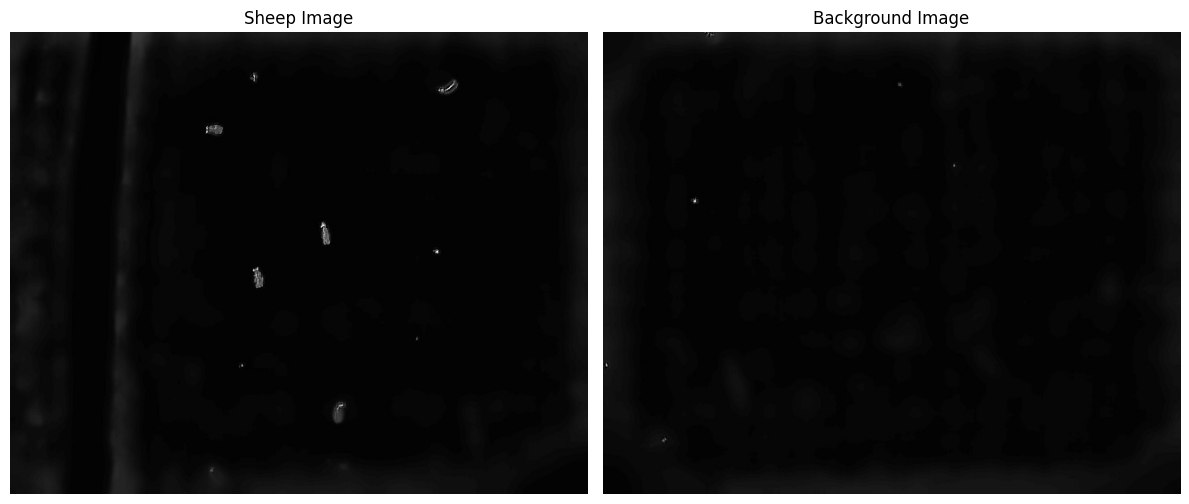

In [2]:
image_folder = '../dataset/images/enhanced/'
sheep_image_name = 'DJI_20240125160538_0008_T.JPG'
background_image_name = 'DJI_20240125160808_0083_T.JPG'

sheep_image = load_image(f'{image_folder}/{sheep_image_name}')
background_image = load_image(f'{image_folder}/{background_image_name}')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(sheep_image)
axes[0].set_title('Sheep Image')
axes[0].axis('off')

# Plot the background image
axes[1].imshow(background_image)
axes[1].set_title('Background Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
def show_sheep(cut_out_sheep: np.ndarray):
    background = np.zeros((100, 100, 3), dtype=np.uint8)
    h_bg, w_bg = background.shape[:2]
    h_cut, w_cut = cut_out_sheep.shape[:2]
    y_off, x_off = (h_bg - h_cut) // 2, (w_bg - w_cut) // 2

    background[y_off:y_off+h_cut, x_off:x_off+w_cut] = cut_out_sheep

    # Show
    plt.figure(figsize=(2, 2))
    plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


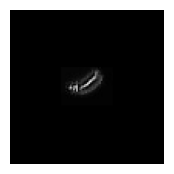

In [4]:
from typing import Tuple


def cut_sheep(img: np.ndarray, bounding_box: Tuple[int, int, int, int]) -> np.ndarray:
    x, y, width, height = bounding_box
    x_min = x
    y_min = y
    x_max = x + width
    y_max = y + height
    sheep_cropped = img[y_min:y_max, x_min:x_max]
    return sheep_cropped

# Cut out the sheep
sheep_cutout = cut_sheep(sheep_image, (469, 52, 34, 25))
show_sheep(sheep_cutout)


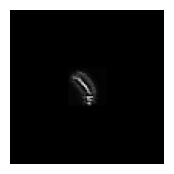

In [5]:
def rotate_sheep(img: np.ndarray, angle: int) -> np.ndarray:
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle=angle, scale=1.0)
    return cv2.warpAffine(img, M, (w, h))

rotated_sheep = rotate_sheep(sheep_cutout, 90)
show_sheep(rotated_sheep)

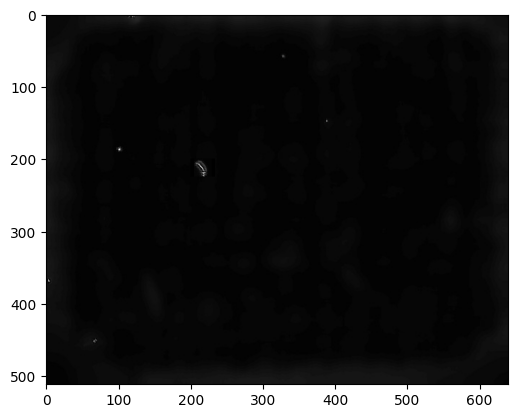

In [6]:
def paste_sheep(sheep: np.ndarray, background: np.ndarray, x: int, y: int) -> np.ndarray:
    result = background.copy()
    sheep_height, sheep_width = sheep.shape[:2]

    result[y:y+sheep_height, x:x+sheep_width] = sheep
    return result

pasted_sheep = paste_sheep(rotated_sheep, background_image, 200, 200)
plt.imshow(pasted_sheep)

In [12]:
from typing import List, Tuple
import pandas as pd
import os


images = os.listdir(image_folder)

annotations = pd.read_excel('../dataset/annotations.xlsx')
sheep_images = annotations['image_name'].unique()
background_images = [img for img in images if img not in sheep_images]

print(f'{len(sheep_images)} images with sheep, {len(background_images)} images without sheep.')

def get_bounding_boxes(image_name: str) -> List[Tuple[int, int, int, int]]:
    image_rows = annotations.loc[annotations['image_name'] == image_name]

    boxes = []
    for _, row in image_rows.iterrows():
        x, y, width, height = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']
        boxes.append((int(x), int(y), int(width), int(height)))

    return boxes

43 images with sheep, 133 images without sheep.


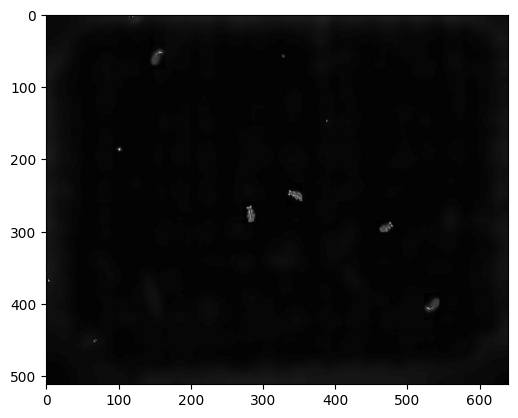

In [13]:
import random

def generate_image(sheep_image: np.ndarray, background_image: np.ndarray, bounding_boxes: List[Tuple[int, int, int, int]], num_sheep: int) -> Tuple[np.ndarray, List[Tuple[int, int, int, int]]]:
    generated_image = background_image.copy()
    placed_bounding_boxes = []  

    for _ in range(num_sheep):
        if not bounding_boxes:
            break 

        bounding_box = random.choice(bounding_boxes)

        # Cut and rotate the sheep
        sheep = cut_sheep(sheep_image, bounding_box)
        sheep = rotate_sheep(sheep, random.randint(0, 360))

        sheep_height, sheep_width = sheep.shape[:2]
        background_height, background_width = generated_image.shape[:2]

        x = random.randint(0, background_width - sheep_width)
        y = random.randint(0, background_height - sheep_height)

        generated_image = paste_sheep(sheep, generated_image, x, y)
        placed_bounding_boxes.append((x, y, sheep_width, sheep_height))  # Save new box

    return generated_image, placed_bounding_boxes

sheep_boxes = get_bounding_boxes(sheep_image_name)
generated_image, _ = generate_image(sheep_image, background_image, sheep_boxes, 5)

plt.imshow(generated_image)

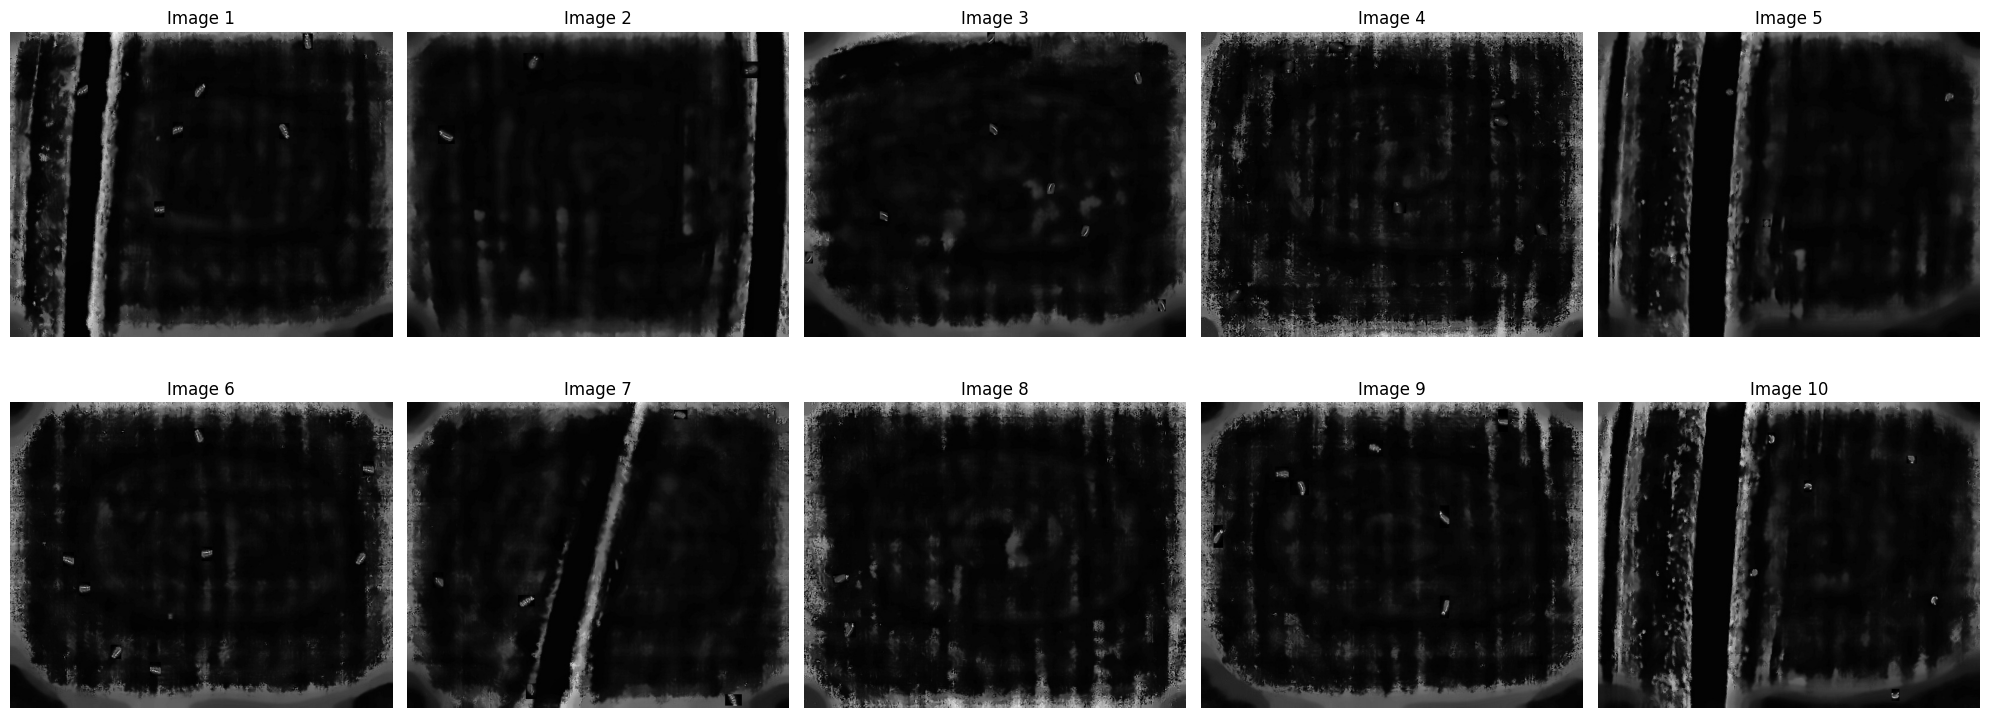

In [25]:
import math

def generate_images(image_folder: str, sheep_images: List[str], background_images: List[str], num_images: int, min_sheep = 2, max_sheep = 8) -> Tuple[np.ndarray, List[Tuple[int, int, int, int]]]:
    generated_images = []

    for _ in range(num_images):
        sheep_image_name = random.choice(sheep_images)
        background_image_name = random.choice(background_images)

        sheep_image = load_image(f'{image_folder}/{sheep_image_name}')
        background_image = load_image(f'{image_folder}/{background_image_name}')

        bounding_boxes = get_bounding_boxes(sheep_image_name)

        num_sheep = random.randint(min_sheep, max_sheep)
        image, sheep_annotations = generate_image(sheep_image, background_image, bounding_boxes, num_sheep)

        generated_images.append((image, sheep_annotations))
    
    return generated_images


images_with_annotations = generate_images(image_folder, sheep_images, background_images, 10)

num_images = len(images_with_annotations)
cols = 5  # How many images per row
rows = math.ceil(num_images / cols)  # Automatically calculate how many rows needed

plt.figure(figsize=(cols * 4, rows * 4))  # Adjust figure size automatically

for idx, (img, _) in enumerate(images_with_annotations):
    plt.subplot(rows, cols, idx + 1)  # rows, cols, index
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Image {idx + 1}')

plt.tight_layout()
plt.show()

In [10]:
output_folder = '../dataset/images/generated' 
os.makedirs(output_folder, exist_ok=True)

generated_image_annotations = []

for idx, (image, annotations) in enumerate(images_with_annotations):
    image_filename = f"generated_image_{idx + 1}.jpg"
    image_path = os.path.join(output_folder, image_filename)
    cv2.imwrite(image_path, image)

    for (x, y, width, height) in annotations:
        generated_image_annotations.append({
            'image_name': image_filename,
            'bbox_x': x,
            'bbox_y': y,
            'bbox_width': width,
            'bbox_height': height
        })


annotations_df = pd.DataFrame(generated_image_annotations)
annotations_csv_path = os.path.join(output_folder, "annotations.xlsx")
annotations_df.to_excel(annotations_csv_path, index=False)

print(f"Saved {len(images_with_annotations)} images and annotations to '{output_folder}'")



Saved 10 images and annotations to '../dataset/images/generated'
